In [1]:
# Setup e Importazioni
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy #deepcopy è una funzione che crea una copia completamente indipendente di un oggetto complesso (come liste annidate o dizionari che contengono altre liste/dizionari).

# Configurazione del seed per la riproducibilità
rnd = np.random
rnd.seed(0)

# Costo Massimo per gestire vincoli non rispettati (archi inesistenti)
MAX_COST = 9999999

In [2]:
# Definizione dei Dati del VRPTW (N=10)

n = 50   # Numero punti vendita
# Deposito: 's'=0 (partenza) e 't'=n+1 (arrivo)
xc = rnd.rand(n+1)*200   # Vettore di coordinate x dei vari nodi
xc = np.append(xc, xc[0]) # Coordinate x di 't' uguali a 's'
yc = rnd.rand(n+1)*100   # Vettore di coordinate y dei vari nodi
yc = np.append(yc, yc[0]) # Coordinate y di 't' uguali a 's'

P = [il for il in range(1,n+1)]                  # Insieme P dei punti vendita (Clienti: 1 a 10)
N = [0] + P + [n+1]                                      # Insieme N dei nodi ('s'=0, 't'=n+1)

# Insieme A degli archi
A = [(i,j) for i in N for j in N if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)]

# Costi associati a ogni arco
c = {(i,j): np.random.randint(2,15) for i,j in A}

# Tempo di percorrenza degli archi (posto come distanza euclidea)
t = {(i,j): int(np.hypot(xc[i]-xc[j], yc[i]-yc[j])) for i,j in A}

# Richiesta per ogni nodo
np.random.seed(0)
d = {i: np.random.randint(10,15) for i in P}
d[0] = 0         # Nodo deposito 's'
d[n+1] = 0       # Nodo deposito 't'

V = list(range(1, 11))                                              # Insieme V dei veicoli
Q = {1:90, 2:90, 3:80, 4:80, 5:90, 6:90, 7:80, 8:80, 9:90, 10:100}  # Insieme Q delle capacità massime dei veicoli

# Finestre di apertura dei punti di vendita
a = {}
b = {}
# Orari depositi
a[0], b[0] = 0, 1500
a[n+1], b[n+1] = 0, 1500
# Divisione in 3 fasce orarie: {[20,480], [50,900], [710, 1450]}
for i in P:
    r = i % 3
    if r == 1:
        a[i], b[i] = 20, 560
    elif r == 2:
        a[i], b[i] = 50, 1200
    else:
        a[i], b[i] = 710, 1450

# Tempo di servizio
s = {(i,k): np.random.randint(3,5) if i!=0 and i!=n+1 else 0 for i in N for k in V}

# Stato globale (usato per simulare gli attributi )
STATE = {}

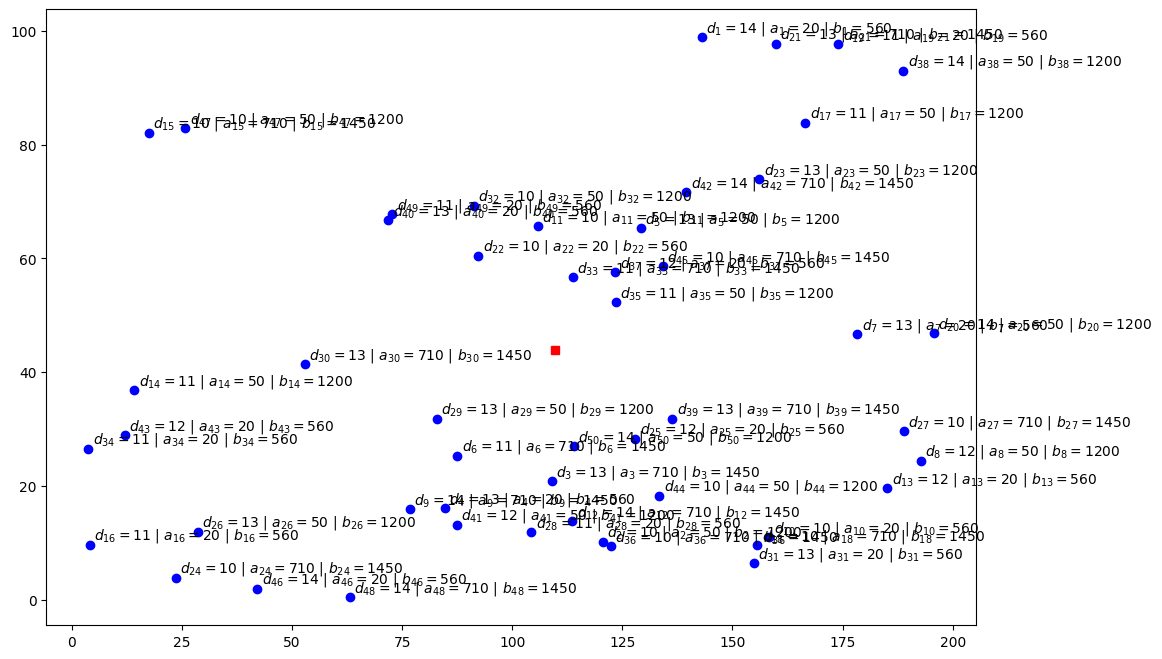

In [3]:
# Visualizzazione deposito e punti vendita
plt.figure(figsize=(12,8))
plt.plot(xc[0], yc[0], c='r', marker='s')     # Nodo deposito
plt.scatter(xc[1:n+1], yc[1:n+1], c='b')          # Nodi punti vendita
for i in P:
  plt.annotate("$d_{%i}=%d$ | $a_{%i}=%d$ | $b_{%i}=%d$" %(i, d[i], i, a[i], i, b[i]), (xc[i]+1, yc[i]+1))

In [4]:
# --- FUNZIONI DI VERIFICA VRPTW ---

# Verifica del vincolo di capacità
def verifica_capacità (rotta, d, capacità):
    domanda_totale = 0
    # Scorre tutti i clienti nella rotta
    for i in rotta:
        # Accumula la domanda ('d' è un dizionario {cliente: richiesta})
        domanda_totale += d[i]
    # Restituisce True se la domanda totale è inferiore o uguale alla capacità del veicolo
    return domanda_totale <= capacità

# Verifica del vincolo sulla finestra temporale
def verifica_finestra (rotta, t, s, a, b, veicolo_id):

    n_plus_1 = len(P) + 1 # P è la lista globale dei clienti. Questo è l'indice del deposito di arrivo 't'
    tempo_corrente = 0    # Tempo di arrivo al nodo corrente. Inizia d 0 (partenza da 's')
    nodo_precedente = 0   # Deposito di partenza 's'

    for i in rotta:
        # Aggiornamento tempo di viaggio: aggiunge il tempo di percorrenza dall'ultimo nodo visitato
        tempo_corrente += t.get((nodo_precedente, i), MAX_COST)
        # Se il costo di viaggio è MAX_COST (arco inesistente o vincolo irrealizzabile), la rotta non è ammissibile
        if tempo_corrente >= MAX_COST: return False

        # Verifica Tempo di Attesa: Nel caso in cui arrivo prima dell'orario di apertura (a[i]), aspetto
        if tempo_corrente < a[i]:
            tempo_corrente = a[i]

        # Verifica Violazione Finestra Temporale: Se arrivo dopo l'orario di chiusura (b[i]), il vincolo è violato
        if tempo_corrente > b[i]:
            return False

        # Aggiunta del tempo di servizio al tempo corrente
        tempo_corrente += s.get((i, veicolo_id), 0)
        nodo_precedente = i # Il nodo corrente diventa il nodo precedente per il prossimo segmento

    # Verifico il ritorno al deposito 't' (nodo n+1)
    if (nodo_precedente, n_plus_1) in t:
        # Aggiunge il tempo di viaggio dall'ultimo cliente al deposito 't'
        tempo_corrente += t.get((nodo_precedente, n_plus_1), MAX_COST)
        # Verifica che il tempo di arrivo finale sia minore o uguale all'orario di chiusura del deposito
        if tempo_corrente >= MAX_COST or tempo_corrente > b[n_plus_1]:
            return False

    return True # Se tutti i vincoli sono rispettati, la rotta è ammissibile



# --- FUNZIONI DI LOGICA TABU SEARCH ---

# Calcolo del costo totale di una soluzione
def fitness(solution, c, depot_s, depot_t):
    total_cost = 0
    # La 'solution' è un dizionario {veicolo_id: [cliente1, cliente2, ...]}
    for veiculo_id, route in solution.items():
        if route:
            # Si aggiunge il costo dell'arco dal deposito in partenza 's' al primo cliente della rotta
            total_cost += c.get((depot_s, route[0]), MAX_COST)

            # Si aggiungono i costi tra i clienti nella rotta
            for i in range(len(route) - 1):
                # Aggiunge il costo dell'arco tra il cliente i e il cliente i+1
                total_cost += c.get((route[i], route[i+1]), MAX_COST)

            # Si aggiunge il costo dell'arco dall'ultimo cliente al deposito in arrivo 't'
            total_cost += c.get((route[-1], depot_t), MAX_COST)
    return total_cost


# Verifica che siano rispettati i vincoli di capacità e finestra temporale
def is_feasible(solution, d, Q, t, s, a, b):
    # Nota: la soluzione è un dizionario {veicolo_id: rotta}
    for veicolo_id, route in solution.items():
        # Chiama la funzione di verifica capacità per la rotta specifica
        if not verifica_capacità(route, d, Q[veicolo_id]):
            return False # Se una rotta non è ammissibile per capacità, fallisc
        # Chiama la funzione di verifica finestra temporale per la rotta specifica
        if not verifica_finestra(route, t, s, a, b, veicolo_id):
            return False # Se una rotta non è ammissibile per finestra temporale, fallisce
    return True # L'intera soluzione è ammissibile


# Genera una soluzione iniziale ammissibile, tramite strategia Greedy di inserimento
def initialize_solution(P, V, Q, d, t, s, a, b, c, depot_s, depot_t):
    remaining_clients = list(P)
    # Ordina i clienti in base all'orario di chiusura (Euristica per rispettare i Time Window)
    remaining_clients.sort(key=lambda c_id: b[c_id])
    initial_solution = {v: [] for v in V}

    max_attempts = len(P) * len(V) * 20 # Limite per evitare loop infiniti
    attempt_count = 0

    while remaining_clients:
        client_to_assign = remaining_clients.pop(0) # Prende il prossimo cliente da assegnare
        best_insertion = None
        min_route_cost = MAX_COST

        # Cerca la migliore posizione e il miglior veicolo per l'inserimento
        for veicolo_id in V:
            current_route = initial_solution[veicolo_id]
            for pos in range(len(current_route) + 1):
                # Crea la rotta temporanea con l'inserimento
                temp_route = current_route[:pos] + [client_to_assign] + current_route[pos:]

                # Verifica che la rotta modificata sia ancora ammissibile (vincoli VRPTW)
                if is_feasible({veicolo_id: temp_route}, d, Q, t, s, a, b):
                    temp_solution = deepcopy(initial_solution)
                    temp_solution[veicolo_id] = temp_route
                    # Calcola il costo totale della soluzione dopo l'inserimento
                    new_cost = fitness(temp_solution, c, depot_s, depot_t)

                    # Trovato un inserimento migliore (Greedy)
                    if new_cost < min_route_cost:
                        min_route_cost = new_cost
                        best_insertion = (veicolo_id, temp_route)

        # Se è stata trovata una posizione ammissibile
        if best_insertion:
            veicolo_id, final_route = best_insertion
            initial_solution[veicolo_id] = final_route # Aggiorna la soluzione con il miglior inserimento
        else:
            # Se nessun veicolo/posizione è ammissibile, rimette il cliente in coda e riprova
            remaining_clients.append(client_to_assign)

        attempt_count += 1
        if attempt_count > max_attempts:
            # Lancia un'eccezione se non riesce a trovare una soluzione ammissibile dopo troppi tentativi
            raise Exception("Impossibile generare una soluzione iniziale ammissibile. Controlla i vincoli.")

    initial_cost = fitness(initial_solution, c, depot_s, depot_t)
    # Restituisce la soluzione iniziale trovata e il suo costo
    return initial_solution, initial_cost


# Genera vicini tramite mosse di SWAP ammissibili, sia inter-rotta che intra-rotta
def find_neighborhood(current_solution, TABU, d, Q, t, s, a, b):
    neighborhood = [] # Lista per le soluzioni vicine ammissibili
    moves = []        # Lista per le mosse corrispondenti
    current = current_solution
    vehicle_ids = list(current.keys())

    # Itera su tutti i nodi (clienti) in tutte le rotte
    for v1_id in vehicle_ids:
        route1 = current[v1_id]
        for idx1 in range(len(route1)):
            node1 = route1[idx1]

            # 1. Swap Intra-Rotta (scambio all'interno della stessa rotta)
            for idx2 in range(idx1 + 1, len(route1)):
                node2 = route1[idx2]
                move = (node1, node2); inverse_move = (node2, node1)

                # Controllo Tabu: Ignora le mosse proibite
                if move not in TABU and inverse_move not in TABU:
                    new_solution = deepcopy(current)
                    new_route1 = new_solution[v1_id]
                    # Esegue lo swap dei nodi
                    new_route1[idx1], new_route1[idx2] = new_route1[idx2], new_route1[idx1]

                    # Verifica l'ammissibilità della rotta modificata
                    if is_feasible({v1_id: new_route1}, d, Q, t, s, a, b):
                        neighborhood.append(new_solution)
                        moves.append(move)

            # 2. Swap Inter-Rotta (scambio tra due rotte diverse)
            for v2_id in vehicle_ids:
                if v1_id != v2_id:
                    route2 = current[v2_id]
                    for idx2 in range(len(route2)):
                        node2 = route2[idx2]
                        move = (node1, node2); inverse_move = (node2, node1)

                        # Controllo Tabu: Ignora le mosse proibite
                        if move not in TABU and inverse_move not in TABU:
                            new_solution = deepcopy(current)
                            new_route1 = new_solution[v1_id]
                            new_route2 = new_solution[v2_id]

                            # Esegue lo swap inter-rotta
                            new_route1[idx1], new_route2[idx2] = new_route2[idx2], new_route1[idx1]

                            # Verifica l'ammissibilità di entrambe le rotte modificate
                            if is_feasible({v1_id: new_route1, v2_id: new_route2}, d, Q, t, s, a, b):
                                neighborhood.append(new_solution)
                                moves.append(move)

    return neighborhood, moves


# Aggiorna la lista Tabu con la nuova mossa e decrementa il tenure delle mosse esistenti
def update_tabu_list(TABU, best_move, tabu_size):
    if best_move is not None:
        node1, node2 = best_move
        inverse_move = (node2, node1)

        # Aggiunge la mossa e la sua inversa alla lista Tabu con il tenure specificato
        TABU[best_move] = tabu_size
        TABU[inverse_move] = tabu_size

    # Decremento del tenure
    moves_to_delete = []
    # Itera su tutte le mosse nella lista Tabu
    for move in list(TABU.keys()):
        TABU[move] -= 1 # Decrementa il tenure
        if TABU[move] <= 0:
            moves_to_delete.append(move) # Segna per la cancellazione se il tenure scade

    # Rimuove le mosse con tenure scaduto
    for move in moves_to_delete:
        del TABU[move]

In [5]:
# --- FUNZIONE PRINCIPALE DI RICERCA ---

def tabu_search(P, c, t, d, a, b, V, Q, s, n_iters=1000, tabu_size=50):

    # Parametri del Deposito
    depot_s = 0 	 	 # Deposito in partenza 's' (indice 0)
    depot_t = len(P) + 1 # Deposito in arrivo 't' (indice N+1)

    # Stato della ricerca (popola la variabile globale STATE)
    global STATE
    # Dizionario che mantiene lo stato corrente e il migliore stato globale
    STATE = {
        'best_solution': None, 		# La migliore soluzione *globale* mai trovata
        'best_cost': MAX_COST, 		# Il costo della migliore soluzione globale
        'current_solution': None, 	# La soluzione corrente su cui si basa la ricerca (potrebbe essere peggiore della 'best_solution')
        'current_cost': MAX_COST, 	# Il costo della soluzione corrente
        'TABU': {}, 	 	 	 	# Dizionario che contiene le mosse proibite e il loro tenure rimanente
        'tabu_size': tabu_size,		# Durata di proibizione per una mossa (tenure)
        'n_iters': n_iters,			# Numero massimo di iterazioni
        # Memorizza tutti i parametri del problema per l'accesso dalle funzioni ausiliarie
        'depot_s': depot_s, 'depot_t': depot_t,
        'c': c, 't': t, 'd': d, 'a': a, 'b': b, 'V': V, 'Q': Q, 's': s
    }

    try:
        # 1. Fase di Inizializzazione
        initial_solution, initial_cost = initialize_solution(P, V, Q, d, t, s, a, b, c, depot_s, depot_t)

        # Imposta lo stato iniziale: soluzione corrente = soluzione iniziale
        STATE['current_solution'] = initial_solution
        STATE['current_cost'] = initial_cost

        # Imposta la migliore soluzione globale = soluzione iniziale (usiamo deepcopy per non alterarla)
        STATE['best_solution'] = deepcopy(initial_solution)
        STATE['best_cost'] = initial_cost
    except Exception as e:
        print(f"Errore: {e}")
        return None, None

    print(f"Inizio Ricerca Tabu. Costo iniziale: {STATE['best_cost']:.2f}")

    # 2. Ciclo Principale della Ricerca Tabu
    for iter_count in range(STATE['n_iters']):

        # Genera il vicinato (insieme di soluzioni raggiungibili con una mossa singola)
        # Vengono scartate immediatamente le mosse esplicitamente proibite (Tabu) O che portano a soluzioni non ammissibili (vincoli VRPTW violati)
        neighborhood, moves = find_neighborhood(
            STATE['current_solution'], STATE['TABU'], STATE['d'], STATE['Q'], STATE['t'],
            STATE['s'], STATE['a'], STATE['b']
        )

        if not neighborhood:
            # Condizione di stallo: se non ci sono vicini ammissibili e non Tabu, la ricerca si ferma
            print("Nessun vicino ammissibile trovato. Termine ricerca.")
            break

        best_candidate = None
        best_candidate_cost = MAX_COST
        best_move = None # Mossa che genera il miglior candidato

        # 3. Selezione del Miglior Vicino (anche se Tabu, con Aspirazione)
        for nb, move in zip(neighborhood, moves):
            nb_cost = fitness(nb, STATE['c'], STATE['depot_s'], STATE['depot_t'])
            is_tabu = move in STATE['TABU'] # Controlla se la mossa è correntemente proibita

            # Criterio di Aspirazione:
            # Accetta il candidato se:
            # a) Non è Tabu.
            # b) È Tabu, MA il suo costo (nb_cost) è STRETTAMENTE MIGLIORE del miglior costo globale ('best_cost').
            if not is_tabu or (is_tabu and nb_cost < STATE['best_cost']):
                # Se è il candidato migliore finora trovato nel vicinato
                if nb_cost < best_candidate_cost:
                    best_candidate_cost = nb_cost
                    best_candidate = nb
                    best_move = move

        # 4. Aggiornamento dello Stato
        if best_candidate is not None:
            # Imposta il miglior candidato trovato come la nuova soluzione corrente
            STATE['current_solution'] = best_candidate
            STATE['current_cost'] = best_candidate_cost

            # Verifica e aggiorna la migliore soluzione globale
            if STATE['current_cost'] < STATE['best_cost']:
                STATE['best_cost'] = STATE['current_cost']
                # Salva la soluzione migliore (Deepcopy essenziale!)
                STATE['best_solution'] = deepcopy(STATE['current_solution'])

            # Aggiornamento Lista Tabu: Proibisce la mossa appena eseguita per un certo tenure
            update_tabu_list(STATE['TABU'], best_move, STATE['tabu_size'])

        # Stampa l'avanzamento ogni 100 iterazioni
        if (iter_count + 1) % 100 == 0:
            print(f"Iterazione {iter_count+1}/{STATE['n_iters']} - Costo corrente: {STATE['current_cost']:.2f} | Costo migliore: {STATE['best_cost']:.2f}")

    print(f"\nRicerca Tabu completata. Costo Finale: {STATE['best_cost']:.2f}")
    return STATE['best_solution'], STATE['best_cost']

Inizio Ricerca Tabu. Costo iniziale: 276.00
Iterazione 100/1000 - Costo corrente: 179.00 | Costo migliore: 174.00
Iterazione 200/1000 - Costo corrente: 188.00 | Costo migliore: 170.00
Iterazione 300/1000 - Costo corrente: 191.00 | Costo migliore: 170.00
Iterazione 400/1000 - Costo corrente: 198.00 | Costo migliore: 170.00
Iterazione 500/1000 - Costo corrente: 204.00 | Costo migliore: 170.00
Iterazione 600/1000 - Costo corrente: 194.00 | Costo migliore: 170.00
Iterazione 700/1000 - Costo corrente: 190.00 | Costo migliore: 170.00
Iterazione 800/1000 - Costo corrente: 194.00 | Costo migliore: 170.00
Iterazione 900/1000 - Costo corrente: 183.00 | Costo migliore: 170.00
Iterazione 1000/1000 - Costo corrente: 184.00 | Costo migliore: 170.00

Ricerca Tabu completata. Costo Finale: 170.00

--- Risultati Finali ---
Costo Totale Finale: 170.00
Soluzione (Rotta per Veicolo, solo Nodi Cliente):
Veicolo 1 (Cap. 90): Rotta di 7 clienti: [46, 40, 22, 4, 49, 43, 16]
Veicolo 2 (Cap. 90): Rotta di 7 cli

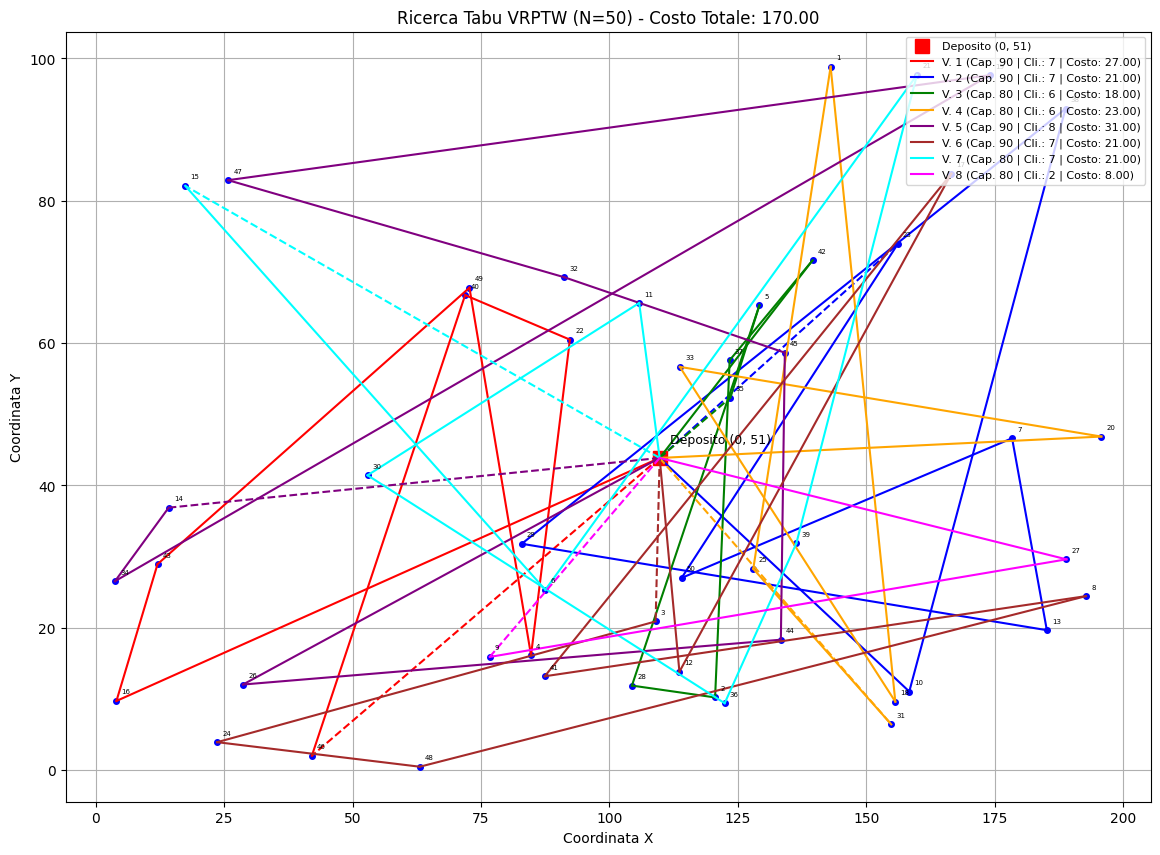

In [6]:
# --- FUNZIONE DI VISUALIZZAZIONE ---

def plot_solution(final_solution, final_cost, xc, yc, n, Q, c, P):
    """Visualizza graficamente la soluzione ottima trovata nel piano (x, y)."""

    # Parametri del Deposito
    depot_s = 0 	 	 # Indice del deposito di partenza ('s')
    depot_t = len(P) + 1 # Indice del deposito di arrivo ('t')

    # Colori predefiniti per distinguere visivamente le rotte dei veicoli
    colori = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'lime', 'gold']

    # Inizializza la figura per il plot con una dimensione specifica
    plt.figure(figsize=(14, 10))

    # --- Disegno dei Nodi ---

    # 1. Disegna il Deposito (s e t)
    # 'rs' = marcatore quadrato rosso. Etichetta per la legenda.
    plt.plot(xc[0], yc[0], 'rs', markersize=10, label=f'Deposito (0, {n+1})')
    # Aggiunge un'etichetta testuale al deposito sul grafico
    plt.text(xc[0]+2, yc[0]+2, f'Deposito (0, {n+1})', fontsize=9)

    # 2. Disegna i Punti Cliente (P)
    for i in P:
        # 'bo' = marcatore circolare blu.
        plt.plot(xc[i], yc[i], 'bo', markersize=4)
        # Aggiunge l'ID del cliente vicino al punto
        plt.annotate(f"{i}", (xc[i]+1, yc[i]+1), fontsize=5)

    # --- Disegno delle Rotte ---

    if final_solution is not None:
        # Itera su ciascun veicolo (k) e la sua rotta
        for k, rotta in final_solution.items():
            # Seleziona un colore ciclico per il veicolo (k-1 per l'indice base 0)
            col = colori[(k-1) % len(colori)]

            if rotta:
                # Calcolo del costo della rotta (usando la funzione fitness definita in precedenza)
                rotta_costo = fitness({k:rotta}, c, depot_s, depot_t)

                # 1. Percorso dal Deposito (0) -> Primo cliente (rotta[0])
                # linestyle='--' per indicare il tratto di andata
                plt.plot([xc[0], xc[rotta[0]]], [yc[0], yc[rotta[0]]], color=col, linewidth=1.5, linestyle='--')

                # 2. Percorso tra i clienti intermedi
                for i in range(len(rotta) - 1):
                    n1, n2 = rotta[i], rotta[i+1]
                    # Disegna la linea tra il cliente i e il cliente i+1
                    plt.plot([xc[n1], xc[n2]], [yc[n1], yc[n2]], color=col, linewidth=1.5)

                # 3. Percorso dall'Ultimo cliente (rotta[-1]) -> Deposito (n+1)
                # Aggiunge l'etichetta finale per la legenda
                plt.plot([xc[rotta[-1]], xc[n+1]], [yc[rotta[-1]], yc[n+1]],
                         color=col, linewidth=1.5,
                         # Dettagli del veicolo nella legenda
                         label=f'V. {k} (Cap. {Q[k]} | Cli.: {len(rotta)} | Costo: {rotta_costo:.2f})',
                         linestyle='-') # linestyle='-' per indicare il tratto di ritorno

    # --- Configurazione Grafico ---

    # Gestisce potenziali etichette duplicate nella legenda (ad esempio, se il deposito è etichettato due volte)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Mostra la legenda con i dettagli dei veicoli
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)

    # Imposta il titolo e le etichette degli assi
    plt.title(f"Ricerca Tabu VRPTW (N={n}) - Costo Totale: {final_cost:.2f}")
    plt.xlabel("Coordinata X")
    plt.ylabel("Coordinata Y")
    plt.grid(True) # Mostra la griglia
    plt.show() # Mostra il grafico finale


# --- ESECUZIONE ---

# Lancia la funzione principale di Ricerca Tabu
final_solution, final_cost = tabu_search(P=P, c=c, t=t, d=d, a=a, b=b, V=V, Q=Q, s=s, n_iters=1000, tabu_size=50)

# Stampa Risultati (Output testuale)
print("\n--- Risultati Finali ---")
if final_solution is not None and final_cost is not None:
    print(f"Costo Totale Finale: {final_cost:.2f}")
    print("Soluzione (Rotta per Veicolo, solo Nodi Cliente):")
    # Stampa le rotte finali in formato leggibile
    for veicolo, rotta in final_solution.items():
        if rotta:
            print(f"Veicolo {veicolo} (Cap. {Q[veicolo]}): Rotta di {len(rotta)} clienti: {rotta}")
else:
    print("Nessuna soluzione ammissibile trovata dopo la fase di inizializzazione.")

# Visualizzazione della Soluzione Ottima (Output grafico)
plot_solution(final_solution, final_cost, xc, yc, n, Q, c, P)